### 1. 패키지 설치

In [ ]:
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.3 MB/s eta 0:00:00


In [ ]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, MobileNetV2, ResNet50, EfficientNetB0
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
# import keras_tuner as kt
from tensorflow.keras.utils import to_categorical


### 2. vagetable image dataset 다운로드

In [ ]:
# 구글 코랩에서 데이터셋 다운로드 및 준비
from google.colab import drive
drive.mount('/content/drive')

# # kaggle vagitable image 데이터셋 다운로드
!unzip '/content/drive/MyDrive/archive.zip' -d /content/dataset

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/dataset/Vegetable Images/train/Radish/0001.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0002.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0003.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0004.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0005.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0006.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0007.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0008.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0009.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0010.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0011.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0012.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0013.jpg  
  inflating: /content/dataset/Vegetable I

In [ ]:
# 학습(train), 테스트(test), 검증(validation) 데이터셋 경로 지정
train_dir = 'dataset/Vegetable Images/train'
test_dir = 'dataset/Vegetable Images/test'
val_dir = 'dataset/Vegetable Images/validation'

In [ ]:
# # MobileNetV2 파라미터
image_size = (224, 224)
batch_size = 32

# 학습 데이터 증강
train_datagen = ImageDataGenerator(
    rescale=1./255, # 픽셀 정규화
    rotation_range=20, # 1~20 무작위 회전
    width_shift_range=0.2, # 수평 방향 이동
    height_shift_range=0.2, # 수직 방향 이동
    shear_range=0.2, # 전단 변환
    zoom_range=0.2, # 확대, 축소
    horizontal_flip=0.2, # 뒤집기
    fill_mode='nearest', # 이미지 변형 중 빈 공간 채우기
)

# 테스트, 검증 데이터 정규화
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [ ]:
# 학습 그래프 시각화 정의
def plot_learning_curves(history):
  plt.figure(figsize=(12, 4))

  # Loss plot
  plt.subplot(1, 2, 1)
  plt.plot(history['loss'], label='Training Loss')
  plt.plot(history['val_loss'], label='Validation Loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Accuracy plot
  plt.subplot(1, 2, 2)
  plt.plot(history['accuracy'], label='Training Accuracy')
  plt.plot(history['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.ylim(0, 1)  # Set the y-axis range for accuracy from 0 to 1

In [ ]:
# 전역 변수
input_shape = (224, 224, 3)
num_classes = 15

# 1. 모델 빌딩 함수
def build_model(hp):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    # Dense 레이어의 유닛 수 탐색: 128, 256, 512 중 선택
    dense_units = hp.Choice('dense_units', values=[128, 256, 512])

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(dense_units, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    # 학습률 하이퍼파라미터: 로그 스케일로 탐색
    lr = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 2. 배치 사이즈 튜닝을 위한 커스텀 Tuner 클래스 정의
class MyTuner(kt.tuners.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        # 배치 사이즈 하이퍼파라미터 추가: 16, 32, 64 중 선택
        hp = trial.hyperparameters
        batch_size = hp.Choice('batch_size', values=[16, 32, 64])
        kwargs['batch_size'] = batch_size
        return super(MyTuner, self).run_trial(trial, *args, **kwargs)

# 3. Tuner 생성
tuner = MyTuner(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # 탐색할 하이퍼파라미터 조합 수
    executions_per_trial=1,
    directory='my_dir',
    project_name='mobilenetv2_tuning'
)

# 4. 하이퍼파라미터 탐색 실행
tuner.search(train_generator, epochs=5, validation_data=val_generator)
tuner.results_summary()

# 5. 최적의 하이퍼파라미터 추출
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_lr = best_hps.get('learning_rate')
best_bs = best_hps.get('batch_size')
best_dense_units = best_hps.get('dense_units')

print("✅ Best learning rate:", best_lr)
print("✅ Best batch size:", best_bs)
print("✅ Best dense units:", best_dense_units)

Reloading Tuner from my_dir/mobilenetv2_tuning/tuner0.json
Results summary
Results in my_dir/mobilenetv2_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
dense_units: 128
learning_rate: 0.0009497969456542987
batch_size: 64
Score: 0.9980000257492065

Trial 1 summary
Hyperparameters:
dense_units: 128
learning_rate: 0.000976844384018483
batch_size: 64
Score: 0.9973333477973938

Trial 3 summary
Hyperparameters:
dense_units: 256
learning_rate: 9.052494618776521e-05
batch_size: 64
Score: 0.9950000047683716

Trial 0 summary
Hyperparameters:
dense_units: 512
learning_rate: 1.2419672348410803e-05
batch_size: 16
Score: 0.9786666631698608

Trial 2 summary
Hyperparameters:
dense_units: 256
learning_rate: 1.6723297752560498e-05
batch_size: 64
Score: 0.9776666760444641
✅ Best learning rate: 0.0009497969456542987
✅ Best batch size: 64
✅ Best dense units: 128


In [ ]:

# 6. 최적의 하이퍼파라미터로 모델 생성 및 최종 학습
model = build_model(best_hps)

# 최종 학습을 위한 콜백 정의 (필요에 따라 조정)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)
checkpoint_path = os.path.join('/content/drive/My Drive/models', 'best_model_mobilenetv2.keras')
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1) # 가중치 저장

model.compile(optimizer=Adam(learning_rate=best_lr),
          loss='categorical_crossentropy',
          metrics=['accuracy'])

history = model.fit(train_generator, epochs=20, batch_size=best_bs,
                    validation_data=val_generator, callbacks=[early_stopping, reduce_lr, checkpoint])

model_save_path = os.path.join('/content/drive/My Drive/models', 'model_mobilenetv2_tuning_new.keras')
model.save(model_save_path)


Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4115 - loss: 1.9958
Epoch 1: val_accuracy improved from -inf to 0.97433, saving model to best_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 1023s 2s/step - accuracy: 0.4120 - loss: 1.9942 - val_accuracy: 0.9743 - val_loss: 0.2056 - learning_rate: 9.4980e-05
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8950 - loss: 0.4021
Epoch 2: val_accuracy improved from 0.97433 to 0.98300, saving model to best_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 1001s 2s/step - accuracy: 0.8950 - loss: 0.4020 - val_accuracy: 0.9830 - val_loss: 0.0889 - learning_rate: 9.4980e-05
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9388 - loss: 0.2359
Epoch 3: val_accuracy improved from 0.98300 to 0.98767, saving model to best_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 1000s 2s/step - accuracy: 0.9388 - loss: 0.2359 - val_accuracy: 0.9877 - val_loss: 0.0540 - learning_rate: 9.4980e-05
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"✅ Test loss: {loss}")
print(f"✅ Test accuracy: {accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.9983 - loss: 0.0075
✅ Test loss: 0.009371351450681686
✅ Test accuracy: 0.9976666569709778


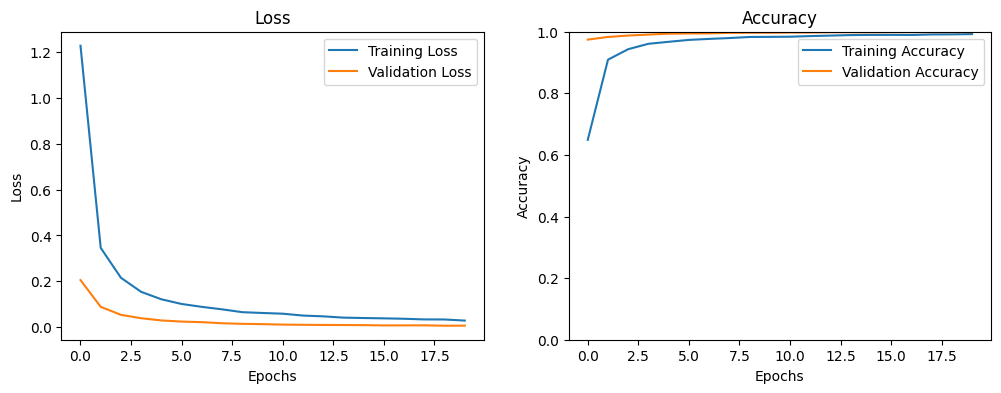

In [ ]:
history_df = pd.DataFrame(history.history)
plot_learning_curves(history_df)

In [ ]:
# 저장된 모델 로드
model_load_path = os.path.join('/content/drive/My Drive/models', 'model_mobilenetv2_tuning_new.keras')
loaded_model = tf.keras.models.load_model(model_load_path)

# 불러온 모델 확인
loaded_model.summary()


NameError: name 'os' is not defined

In [ ]:
# 불러온 모델 평가
loss, accuracy = loaded_model.evaluate(test_generator)
print(f"✅ Loaded model Test loss: {loss}")
print(f"✅ Loaded model Test accuracy: {accuracy}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.9973 - loss: 0.0095
✅ Loaded model Test loss: 0.009371349588036537
✅ Loaded model Test accuracy: 0.9976666569709778


In [ ]:
# 데이터 예측
# Get the true classes (ground truth) from the test generator
true_classes = test_generator.classes

# Predict probabilities for each class using the model
predictions = loaded_model.predict(test_generator)

# Convert probabilities to predicted class indices (select the class with the highest probability)
predicted_classes = np.argmax(predictions, axis=1)

test_labels=test_generator.class_indices.keys()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step


In [ ]:
# Generate the classification report
# target_names assigns human-readable class names from the test generator
report = classification_report(true_classes, predicted_classes, target_names=test_labels)
print(report)

              precision    recall  f1-score   support

        Bean       1.00      1.00      1.00       200
Bitter_Gourd       1.00      0.99      0.99       200
Bottle_Gourd       1.00      0.99      1.00       200
     Brinjal       0.99      1.00      1.00       200
    Broccoli       0.99      0.99      0.99       200
     Cabbage       1.00      1.00      1.00       200
    Capsicum       1.00      1.00      1.00       200
      Carrot       1.00      1.00      1.00       200
 Cauliflower       1.00      1.00      1.00       200
    Cucumber       0.99      0.99      0.99       200
      Papaya       1.00      1.00      1.00       200
      Potato       1.00      1.00      1.00       200
     Pumpkin       1.00      0.99      1.00       200
      Radish       1.00      1.00      1.00       200
      Tomato       1.00      0.99      1.00       200

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00   

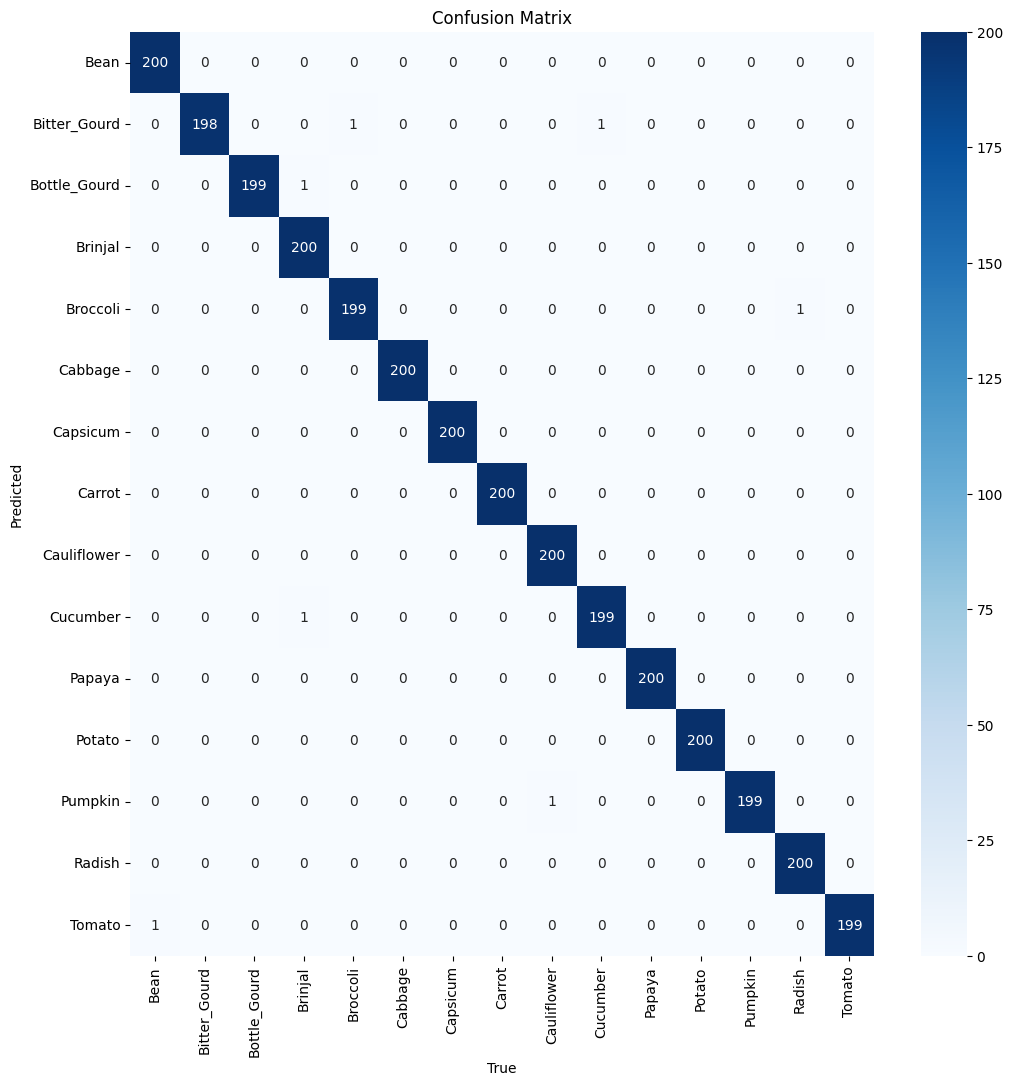

In [ ]:
plt.figure(figsize=(12,12))
cm=confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d',cmap="Blues", xticklabels=test_labels,yticklabels=test_labels)
plt.title("Confusion Matrix")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()